## A Tutorial Signature Verification with the Signver Library

In [1]:
from signver.detector import Detector
from signver.extractor import MetricExtractor
from signver.matcher import Matcher
from signver.utils import data_utils, visualization_utils
from signver.utils.data_utils import invert_img, resnet_preprocess
from signver.utils.visualization_utils import plot_np_array, visualize_boxes, get_image_crops

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


## Instantiate the Detector, Extractor Modules

In [2]:
model_path = "models/detector/small"
detector = Detector()
detector.load(model_path)

In [3]:
model_path = "models/extractor/metric"
extractor = MetricExtractor() 
extractor.load(model_path)

## Download a Test Signature Image

In [4]:
file_url = "https://magazine.art21.org/wp-content/uploads/2009/06/signed-document-by-nam-june-paik-from-the-imas-historical-files.jpg"
file_url_2="https://swimmingfreestyle.net/wp-content/uploads/2019/10/contract-signature-page-example-new-elgin-munity-college-faculty-association-eccfa-of-contract-signature-page-example.png"
file_name = "signdoc.jpg" 
destination_dir = "data/test/localizer"
img_path = data_utils.download_file(file_url_2, file_name,  destination_dir) 

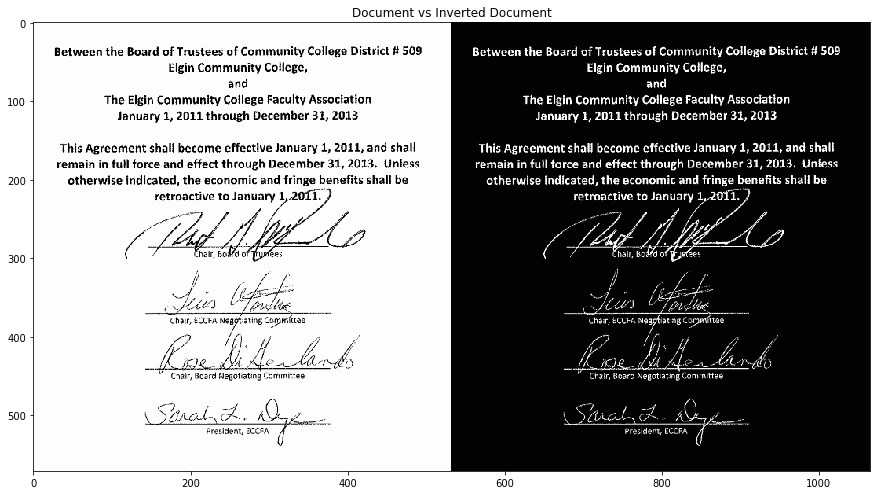

In [5]:
image_np = data_utils.img_to_np_array(img_path)
inverted_image_np = data_utils.img_to_np_array(img_path, invert_image=True)

img_tensor = tf.convert_to_tensor(inverted_image_np)
img_tensor = img_tensor[tf.newaxis, ...]

plot_np_array( np.concatenate((image_np, inverted_image_np ), axis = 1), title="Document vs Inverted Document")

## Get Localization Predictions (Where are Signatures in the Image?)

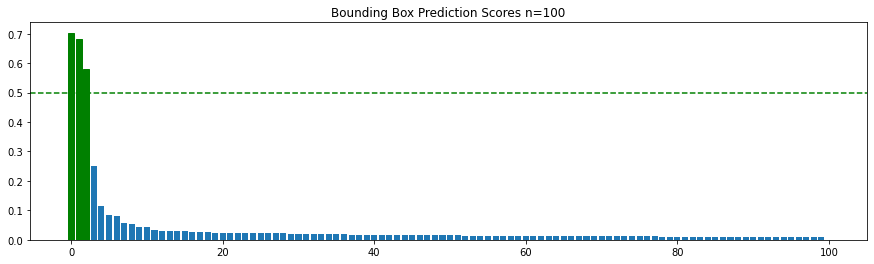

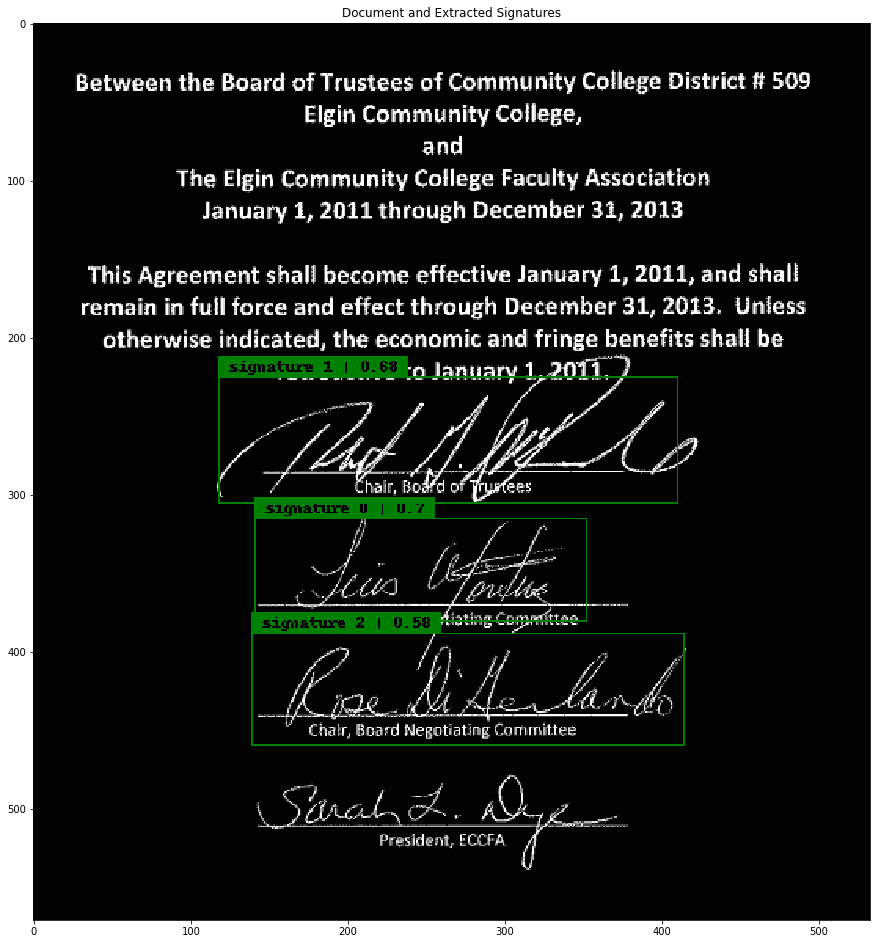

In [6]:
# get a list of bounding box predictions for image
boxes, scores, classes, detections = detector.detect(img_tensor)

# plot confidence scores for each detections
threshold = 0.5
plt.figure(figsize=(15,4))
barlist = plt.bar(range(len(scores)),scores);
[ x.set_color('g') for x in barlist if x.get_height() > threshold]
plt.axline((0, 0.5), (100, 0.5), color="g", linestyle="--");
plt.title("Bounding Box Prediction Scores n=" + str(len(scores)));

# annotate image with bounding boxes above a given threshold and plot 
annotated_image = visualize_boxes(inverted_image_np, boxes, scores, threshold=0.3, color="green")
plot_np_array(annotated_image, title="Document and Extracted Signatures")  

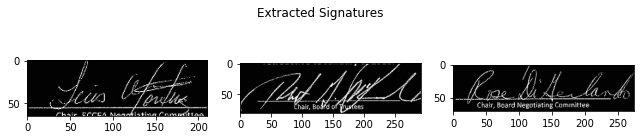

In [7]:
signatures = get_image_crops(inverted_image_np, boxes, scores,  threshold = 0.5, )
plot_np_array(signatures, fig_size=(12,14), ncols=4, title="Extracted Signatures")

## Extract Features from Signatures

/Users/victordibia/projects/cloudera/signatureverification/signver/utils/data_utils.py:19: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like an RGB image
  thresh = threshold_otsu(img_arr)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


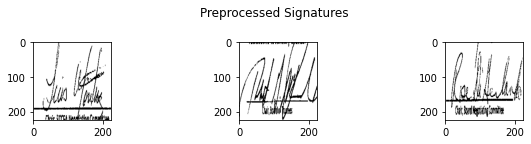

In [8]:
sigs= [resnet_preprocess(x ) for x in signatures]
plot_np_array(sigs,"Preprocessed Signatures")
sigs = np.array(sigs)

In [12]:
feats = extractor.extract(sigs)
feat1,feat2,feat3  = feats[0,:], feats[1,:], feats[2,:]
feat1.shape, feat2.shape, feat3.shape

((256,), (256,), (256,))

## Verify Signatures 

In [10]:
matcher = Matcher()
print( "Similarity between Signature 1 and 1 -> ", matcher.cosine_similarity(feat1,feat1) )
print( "Similarity between Signature 1 and 3 -> ", matcher.cosine_similarity(feat1,feat3) )

print( "Is Signature 1 and 1 from same user ? -> ", matcher.verify(feat1,feat1) )
print( "Is Signature 1 and 3 from same user ? -> ", matcher.verify(feat1,feat3) )


Similarity between Signature 1 and 1 ->  0.0
Similarity between Signature 1 and 3 ->  0.3423307538032532
Is Signature 1 and 1 from same user ? ->  True
Is Signature 1 and 3 from same user ? ->  False


In [11]:
matcher.verify(feat1,feat1), matcher.verify(feat1,feat3), matcher.verify(feat3,feat3),matcher.verify(feat2,feat3)

(True, False, True, False)